In [6]:
import os
import glob
import sys
import warnings
import configparser

import pandas as pd
import numpy as np
import jax.numpy as jnp
from jax import lax, random, vmap
from jax.scipy.special import logsumexp
import flax
from flax.linen import *

import numpyro
from numpyro.distributions import constraints
import numpyro.distributions as dist
from numpyro.diagnostics import hpdi
from numpyro import handlers
from numpyro.infer.autoguide import AutoDiagonalNormal, AutoMultivariateNormal, AutoLaplaceApproximation, AutoDelta, AutoLowRankMultivariateNormal
from numpyro.infer import SVI, Trace_ELBO, Predictive, MCMC, NUTS
from numpyro.util import find_stack_level, not_jax_tracer
from tqdm.auto import trange, tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

sys.path.append('../src/')

# 図のテーマを設定
sns.set_theme(style="darkgrid", context="talk")
# Warningを非表示
warnings.filterwarnings("ignore")
# pandasの表示可能な幅を変更
pd.set_option("display.max_columns", 300)

rng_key = random.PRNGKey(1)

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 実データによる分析

## Largest Sea Levels in Venice

### Description

venice2データフレームは125行、10列です。このデータはAnthony Davison氏によって提供された。j番目の列は、1887年から2011年までのヴェネツィアのj番目に大きい海面を含む。これは、データセットveniceの拡大版である。1935年については最大の6つの測定値のみ、1922年については最大の測定値のみが得られており、対応する行には欠損値が含まれている。各セットの測定値の年は，行名として与えられている．

### Usage

venice2
Format
A data frame with 125 rows and 10 columns.

### Source

Smith, R. L. (1986) Extreme value theory based on the r largest annual events. Journal of Hydrology, 86, 27–43.

### References

Coles, S. G. (2001) An Introduction to Statistical Modeling of Extreme Values. London: Springer-Verlag.

In [7]:
df = pd.read_csv("../../data/venice2.csv", quotechar=" ")
x = jnp.array(df.values)
xmax = x.max(axis=1)

In [8]:
df.head()

,"""1""","""2""","""3""","""4""","""5""","""6""","""7""","""8""","""9""","""10"""
"""1887""",94,93.0,90.0,86.0,85.0,82.0,81.0,80.0,79.0,76.0
"""1888""",90,84.0,84.0,78.0,75.0,75.0,72.0,72.0,69.0,69.0
"""1889""",97,75.0,74.0,72.0,72.0,68.0,68.0,68.0,67.0,67.0
"""1890""",107,104.0,85.0,81.0,79.0,72.0,72.0,70.0,70.0,67.0
"""1891""",87,72.0,70.0,67.0,66.0,66.0,65.0,64.0,63.0,62.0


In [22]:
def model(x=None, N=0):
    loc = numpyro.sample("loc", dist.Normal(loc=100, scale=50))
    scale = numpyro.sample('scale', dist.HalfCauchy(scale=10))
    # xi = numpyro.sample('shape', dist.HalfNormal(scale=1))
    with numpyro.plate('N', N):
        # numpyro.sample(
        #     "obs", 
        #     dist.TransformedDistribution(
        #         base_distribution=dist.Weibull(scale=scale, concentration=xi), 
        #         transforms=dist.transforms.AffineTransform(loc=loc, scale=1)
        #         ),
        #     obs=x
        #     )
        numpyro.sample("obs", dist.Gumbel(loc=loc, scale=scale), obs=x)

kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=5000, num_chains=1)

rng_key = random.PRNGKey(0)

mcmc.run(rng_key, x=xmax, N=len(xmax))
samples = mcmc.get_samples()
mcmc.print_summary()

az.plot_trace(mcmc)
plt.show()

RuntimeError: Cannot find valid initial parameters. Please check your model again.

In [89]:
predictive = Predictive(model, samples)
ppc_samples = predictive(random.PRNGKey(1), N=len(xmax))
idata_ppc = az.from_numpyro(mcmc, posterior_predictive=ppc_samples)

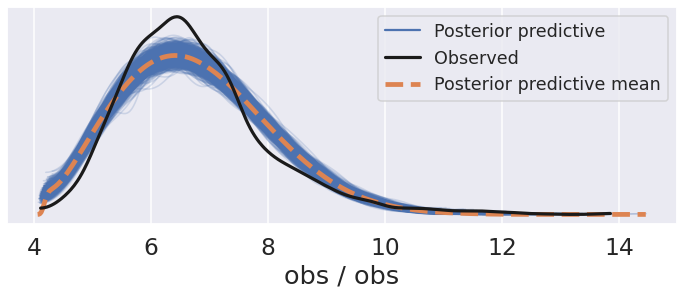

In [91]:
az.plot_ppc(idata_ppc, kind="kde", num_pp_samples=1000, figsize=(12,4))
plt.show()

観測値をうまく説明できない部分が見える。実際Gumbel分布が正解となるのでこれはそう。Gumbelも含めて一気にまるっと推定できないだろうか。